# 注意力评分函数

`sec_nadaraya-watson`使用了高斯核来对查询和键之间的关系建模。
`eq_nadaraya-watson-gaussian`中的高斯核指数部分可以视为*注意力评分函数*（attention scoring function），
简称*评分函数*（scoring function），
然后把这个函数的输出结果输入到softmax函数中进行运算。
通过上述步骤，将得到与键对应的值的概率分布（即注意力权重）。
最后，注意力汇聚的输出就是基于这些注意力权重的值的加权和。

从宏观来看，上述算法可以用来实现`fig_qkv`中的注意力机制框架。
`fig_attention_output`说明了如何将注意力汇聚的输出计算成为值的加权和，
其中$a$表示注意力评分函数。
由于注意力权重是概率分布，
因此加权和其本质上是加权平均值。

![计算注意力汇聚的输出为值的加权和](../img/attention-output.svg)

用数学语言描述，假设有一个查询
$\mathbf{q} \in \mathbb{R}^q$ 和 $m$ 个“键－值”对
$(\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)$，
其中$\mathbf{k}_i \in \mathbb{R}^k$，$\mathbf{v}_i \in \mathbb{R}^v$。
注意力汇聚函数$f$就被表示成值的加权和：

$$f(\mathbf{q}, (\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)) = \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i \in \mathbb{R}^v$$

其中查询$\mathbf{q}$和键$\mathbf{k}_i$的注意力权重（标量）
是通过注意力评分函数$a$将两个向量映射成标量，
再经过softmax运算得到的：

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_{j=1}^m \exp(a(\mathbf{q}, \mathbf{k}_j))} \in \mathbb{R}$$

正如上图所示，选择不同的注意力评分函数$a$会导致不同的注意力汇聚操作。
本节将介绍两个流行的评分函数，稍后将用他们来实现更复杂的注意力机制。

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

## 掩蔽softmax操作

正如上面提到的，softmax操作用于输出一个概率分布作为注意力权重。
在某些情况下，并非所有的值都应该被纳入到注意力汇聚中。
例如，为了在`sec_machine_translation`中高效处理小批量数据集，
某些文本序列被填充了没有意义的特殊词元。
为了仅将有意义的词元作为值来获取注意力汇聚，
可以指定一个有效序列长度（即词元的个数），
以便在计算softmax时过滤掉超出指定范围的位置。
下面的`masked_softmax`函数实现了这样的*掩蔽softmax操作*（masked softmax operation），
其中任何超出有效长度的位置都被掩蔽并置为0。

In [2]:
# 插播下 repeat_interleave 的效果
ri = torch.tensor([1, 2, 3])
torch.repeat_interleave(ri, 2)

tensor([1, 1, 2, 2, 3, 3])

注意：是在最后一个轴（即 feature_dim）上执行掩蔽操作。

**输入 X 的维度一般为 (batch_size，查询的个数，“键-值”对的个数)。**

In [4]:
#@save
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X: 3D 张量。(batch_size, num_steps, feature_dim) 或 (batch_size，查询的个数，“键-值”对的个数)
    # valid_lens: 1D 或 2D 张量。(batch_size,) 或 (batch_size, num_steps)
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)  # 在最后一个维度进行 softmax 操作
    else:
        shape = X.shape  # (batch_size, num_steps, feature_dim)
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])  # 见上一 chunk 中 repeat_interleave 的用法示例
            # 此时 valid_lens 形状为 (batch_size * num_steps,)
        else:
            valid_lens = valid_lens.reshape(-1)  # 展平为一维，(batch_size * num_steps,)

        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其 softmax 输出为 0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]),  # 将 X 的前两维展平为一维 (batch_size * num_steps, feature_dim)
                              valid_lens,
                              value=-1e6)  # e^(-1e6) 趋近于 0
        
        return nn.functional.softmax(X.reshape(shape), dim=-1)

为了演示此函数是如何工作的，
考虑由两个$2 \times 4$矩阵表示的样本，
这两个样本的有效长度分别为$2$和$3$。
经过掩蔽softmax操作，超出有效长度的值都被掩蔽为0。

In [5]:
# 对 X 的最后一个轴（feature_dim）进行掩蔽
# X 形状可理解为 批量大小（batch_size） = 2, 查询个数（queries） = 2, 键值对个数（key_value_num） = 4
# 值的大小代表注意力权重
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4527, 0.5473, 0.0000, 0.0000],
         [0.5657, 0.4343, 0.0000, 0.0000]],

        [[0.2882, 0.4236, 0.2882, 0.0000],
         [0.2610, 0.3477, 0.3913, 0.0000]]])

同样，也可以使用二维张量，为矩阵样本中的每一行指定有效长度。

In [6]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3054, 0.2884, 0.4062, 0.0000]],

        [[0.5009, 0.4991, 0.0000, 0.0000],
         [0.1540, 0.3684, 0.2234, 0.2542]]])

## 加性注意力

一般来说，当查询和键是不同长度的矢量时，可以使用加性注意力作为评分函数。
给定查询 $\mathbf{q} \in \mathbb{R}^q$ 和键 $\mathbf{k} \in \mathbb{R}^k$，
*加性注意力*（additive attention）的评分函数为

$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R}$$

其中可学习的参数是 $\mathbf W_q\in\mathbb R^{h\times q}$、
$\mathbf W_k\in\mathbb R^{h\times k}$ 和
$\mathbf w_v\in\mathbb R^{h}$。
如`eq_additive-attn`所示，
将查询和键连结起来后输入到一个多层感知机（MLP）中，
感知机包含一个隐藏层，其隐藏单元数是一个超参数 $h$。
通过使用 $\tanh$ 作为激活函数，并且禁用偏置项。
注：$a(\mathbf q, \mathbf k)$ 是一个长度为 $k$ 的向量。

下面来实现加性注意力。

In [7]:
#@save
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        # 维度扩展前
        # queries 形状：(batch_size，查询的个数，query_size)
        # keys 形状：(batch_size，“键－值”对的个数，key_size)
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后
        # queries 形状：(batch_size，查询的个数，1，num_hiddens)
        # key 形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)  # (batch_size, num_queries, num_kv_pairs, num_hiddens)
        features = torch.tanh(features)
        
        # self.w_v 仅有一个输出，因此从形状中移除最后那个维度
        # scores 形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        # 掩蔽 softmax 操作（即在 key_value_num(“键-值”对的个数) 维度上进行掩蔽）
        self.attention_weights = masked_softmax(scores, valid_lens)

        # values 形状：(batch_size，“键－值”对的个数，值的维度)
        # 返回值形状： (batch_size，查询的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

用一个小例子来演示上面的`AdditiveAttention`类，
其中查询、键和值的形状为（批量大小，步数或词元序列长度，特征大小），
实际输出为$(2,1,20)$、$(2,10,2)$和$(2,10,4)$。
注意力汇聚输出的形状为（批量大小，查询的步数，值的维度）。

In [8]:
# queries：2 个批次，每个批次有 1 个查询，每个查询有 20 个特征
# keys：2 个批次，每个批次有 10 个键，每个键有 2 个特征
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))

# values 的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)  # repeat 后得到 (2, 10, 4)
# 表示第一个批次中只有前 2 个键有效，第二个批次中前 6 个键有效
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()  # 不会启用 dropout
attention(queries, keys, values, valid_lens)  # (batch_size, num_queries, value_size)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

上述大致运算过程如下：

**1.线性变换：**

- queries 和 keys 分别通过线性层 $W_q$ 和 $W_k$ 投影到隐含空间维度（8个特征）。

- 变换后的 queries 形状为 (2, 1, 8)，keys 形状为 (2, 10, 8)。

**2.特征加法：**

- 使用广播机制，将 queries 和 keys 的维度扩展后相加：

- queries 形状扩展为 (2, 1, 1, 8)。

- keys 形状扩展为 (2, 1, 10, 8)。

- 相加后的 features 形状为 (2, 1, 10, 8)，表示每个查询和每个键之间的组合特征。

**3.计算注意力分数：**

- features 经过 tanh 激活函数，然后通过线性层 $w_v$ 压缩为注意力分数。

- scores 的形状为 (2, 1, 10)，表示每个查询和每个键之间的分数。

**4.使用 valid_lens 掩蔽无效键：**

- masked_softmax 函数通过 valid_lens 掩蔽无效的键，将这些位置的分数设置为非常小的值（如 -1e6），对应的 softmax 输出将会是0。
	
**5.计算加权求和值：**

- 对掩蔽后的 scores 进行 softmax，得到 attention_weights，表示注意力权重。

- attention_weights 形状为 (2, 1, 10)，表示每个查询对10个键的权重分布。

- 使用 torch.bmm（批量矩阵乘法），将 attention_weights 和 values 相乘，得到加权求和值。

- 输出的形状为 (2, 1, 4)，表示每个查询的最终加权值（每个值有4个特征）。

尽管加性注意力包含了可学习的参数，但由于本例子中每个键都是相同的，
所以注意力权重是均匀的，由指定的有效长度决定。

**下图可视化了注意力权重的分布，纵坐标代表 query，横坐标代表 key，颜色深浅代表权重值大小。**

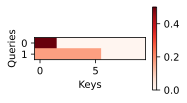

In [9]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')
# 颜色越深，注意力权重越大
# valid_lens = torch.tensor([2, 6])；故第一个查询只有前两个key-value对具有权重，第二个查询只有前六个键值对具有权重

## 缩放点积注意力

使用点积可以得到计算效率更高的评分函数，
但是点积操作要求查询和键具有相同的长度 $d$。
假设查询和键的所有元素都是独立的随机变量，
并且都满足零均值和单位方差，
那么两个向量的点积的均值为 $0$，方差为 $d$。
为确保无论向量长度如何，
点积的方差在不考虑向量长度的情况下仍然是 $1$，
我们再将点积除以 $\sqrt{d}$，
则*缩放点积注意力*（scaled dot-product attention）评分函数为：

$$a(\mathbf q, \mathbf k) = \mathbf{q}^\top \mathbf{k}  /\sqrt{d}$$

在实践中，我们通常从小批量的角度来考虑提高效率，
例如基于 $n$ 个查询和 $m$ 个键－值对计算注意力，
其中查询和键的长度为 $d$，值的长度为 $v$。
查询 $\mathbf Q\in\mathbb R^{n\times d}$、
键 $\mathbf K\in\mathbb R^{m\times d}$ 和值 $\mathbf V\in\mathbb R^{m\times v}$ 的缩放点积注意力是：

$$\mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}$$

下面的缩放点积注意力的实现使用了暂退法进行模型正则化。

In [10]:
#@save
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries 形状：(batch_size，查询的个数，d)，d 是每个查询的特征维度
    # keys 形状：(batch_size，“键－值”对的个数，d)，d 是每个 key 的特征维度
    # values 形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens 形状：(batch_size，) 或者 (batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # transpose 交换 keys 的最后两个维度（转置），以便进行矩阵乘法
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        # scores 形状：(batch_size，查询的个数，“键-值”对的个数)
        # 掩蔽 softmax 操作
        # 在 score 的最后一个维度 key_value_num 进行掩蔽
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

为了演示上述的`DotProductAttention`类，
我们使用与先前加性注意力例子中相同的键、值和有效长度。
对于点积操作，我们令查询的特征维度与键的特征维度大小相同。

In [11]:
# queries：2 个批次，每个批次有 1 个查询，每个查询有 2 个特征
queries = torch.normal(0, 1, (2, 1, 2))
# keys：2 个批次，每个批次有 10 个键，每个键有 2 个特征
keys = torch.ones((2, 10, 2))

attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)  # (batch_size, num_queries, value_size)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

与加性注意力演示相同，由于键包含的是相同的元素，
而这些元素无法通过任何查询进行区分，因此获得了均匀的注意力权重。

**下图可视化了注意力权重的分布，纵坐标代表 query，横坐标代表 key，颜色代表权重值。**

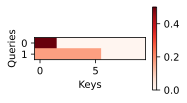

In [12]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')
# 颜色越深，注意力权重越大
# valid_lens = torch.tensor([2, 6])；故第一个查询只有前两个key-value对具有权重，第二个查询只有前六个键值对具有权重

### 为什么需要除以根号d

在点积注意力中，注意力得分（scores）是通过将查询（query）和键（key）的向量进行点积计算的，即：
$\text{scores} = Q \cdot K^\top$。

其中，$Q$ 是查询向量，$K$ 是键向量。如果查询和键的向量维度是 $d$，那么当 $d$ 增大时，向量的点积结果会变得越来越大。这是因为两个随机向量的点积的期望值与它们的维度 $d$ 成正比。因此，随着 $d$ 增大，点积值会变大。

点积值如果过大，输入到 softmax 函数时，会导致数值不稳定。因为 softmax 会放大差异，使得较大的点积值在 softmax 输出中占据主导地位，而较小的点积会接近于零。这样会导致梯度变得非常稀疏，模型训练效果不好。

当 $d$ 很大时，未经缩放的点积可能会导致注意力权重变得极端，只有少数几个键对应的权重接近 1，而其他权重接近 0。这种不平衡的注意力分布会影响梯度的流动，可能会导致**梯度爆炸或消失问题**，影响模型训练。因此，为了平衡这个问题，需要通过除以 $\sqrt{d}$ 来缩放点积值。

## 小结

* 将注意力汇聚的输出计算可以作为值的加权平均，选择不同的注意力评分函数会带来不同的注意力汇聚操作。
* 当查询和键是不同长度的矢量时，可以使用可加性注意力评分函数。当它们的长度相同时，使用缩放的“点－积”注意力评分函数的计算效率更高。

## 练习

1. 修改小例子中的键，并且可视化注意力权重。可加性注意力和缩放的“点－积”注意力是否仍然产生相同的结果？为什么？
2. 只使用矩阵乘法，能否为具有不同矢量长度的查询和键设计新的评分函数？
3. 当查询和键具有相同的矢量长度时，矢量求和作为评分函数是否比“点－积”更好？为什么？

[Discussions](https://discuss.d2l.ai/t/5752)
